# Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения
* [Xavier, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

<img width='800px' src='https://cdn-images-1.medium.com/max/1600/1*q1M7LGiDTirwU-4LcFq7_Q.png'>

Иногда сети пишут на чистом C++, причём код для обучения и инференса (реального прогона в продакшне) — отдельно. Так делают, когда нужен очень быстрый отклик и высокая производительность, но это очень трудоемко.

Большинство людей не усложняют себе жизнь и просто используют фреймворки — с ними можно просто почти декларативно описать, какие операции хотите сделать с данными, а он потом сам построит сеть и подгонит её под данные.

Ваше задание — реализовать свой небольшой фреймворк глубокого обучения на чистом `numpy`. Основное время у вас должно уйти на вывод формул для градиентов, анализ поведения самых часто используемых слоев в современных нейросетях и прочий матан. Хотя бы один раз в жизни это надо сделать, а уже потом пользоваться готовыми абстракциями.

Предполагаемый порядок выполнения:
* Поймите на высоком уровне, как работает алгоритм backpropagation
* Изучите пример с логиситической регрессией, чтобы понять, что от вас в итоге хотят
* Изучите код `Module`
* `Sequential`
* `Linear`
* `SoftMax`
* `CrossEntropy`
* Протестируйте их на логситической регрессии
* Напишите код для решения MNIST
* Дописывайте остальные слои, пока не получите на нём 97%

Оценивание (суммарно до 20 баллов):
* 5 баллов -- что-то хоть как-то обучается, MNIST на валидации >90%
* 2 балла -- MNIST на 95%, дальше по одному баллу за 96%, 97% и 98%. Это будет сделать намного сложнее, чем через PyTorch, потому что вам всё нужно писать самим: более сложные оптимизаторы, learning rate decay, думать про численную стабильность и т. д.
* По 2 балла за слои: LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax

Советы:
* Чтобы лучше понять, что должно в итоге получиться, изучите «игрушечный пример» и вообще эту тетрадку, а потом начните читать `hw_framework.py`, где будет более техничное описание.
* Для дебага проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу. Ещё можете проверить, что на одинаковых данных они дают то же, что их эквиваленты из PyTorch (можно после каждого нового слоя добавить юнит тест через `assert`).
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy.
* Ограничение на срок сдачи большое — до конца всего курса, но рекомендуется закончить примерно за месяц. Дописывайте его постепенно, разбираясь, как работает каждая функция активации.
* Обсуждайте математику и общую архитектуру фреймворка, но не шарьте друг другу код — так не интересно.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

Откройте в Jupyter две тетрадки — эту и `hw_framework.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать.

Архитектура фреймворка вдохновлена PyTorch. Как всегда, если придумаете какой-то более клёвый дизайн — можете использовать его.

In [2]:
%run hw_framework.ipynb

Wall time: 62.7 ms
Wall time: 11 ms


Мы будем использовать самый простой вариант градиентного спуска: просто пройдемся по всем параметрам и сделаем шаги в сторону уменьшения посчитанного заранее градиента.

Есть [более продвинутые методы](http://ruder.io/optimizing-gradient-descent/), но пока что мы их использовать не будем.

In [3]:
def SGD(params, gradients, lr=1e-3):    
    for weights, gradient in zip(params, gradients):
        weights -= lr * gradient

Cоздадим обертку вокруг нашего датасета (просто numpy-евские массивы), которую будем потом использовать, чтобы итерироваться по нему.

In [4]:
def loader(X, Y, batch_size):    
    n = X.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch_idx = indices[start:end]
        yield X[batch_idx], Y[batch_idx]

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. В них ничего менять не надо — они нужны, чтобы отдебажить ваши слои в `hw_framework`.

# Линейная регрессия

In [5]:
n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = np.dot(X, true_w).reshape(n, 1) + np.random.randn(n, 1)/5

print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n), 2)))

best_possible_mse: 17.742680177936386


### Модель

In [6]:
model = Sequential(
    Linear(10, 1),
)

criterion = MSE()

Можете тут потом тестировать остальные свои слои, когда их напишите.

### Обучение

In [7]:
epochs = 10
batch_size = 10
learning_rate = 1e-1

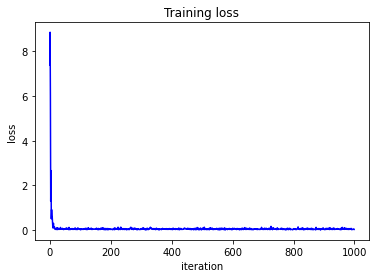

In [8]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

# Логистическая регрессия

Этот пример нужнен для теситрования классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

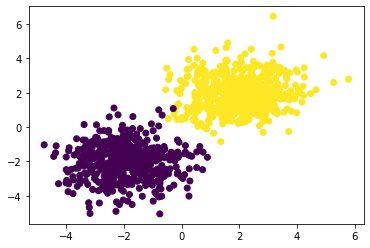

In [9]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([Y, 1-Y])

plt.scatter(X[:,0], X[:,1], c=Y[:, 0])
plt.show()

Обратите внимание на `y`. Он в формате one-hot: у каждого вектора все нули, кроме одной единицы.

Выходные данные в таком формате упростят написание `CrossEntropy`.

### Модель

Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой, софтмакс, и максимизируем правдоподобие.

In [10]:
model = Sequential(
    Linear(2, 2),
    SoftMax()
)

criterion = CrossEntropy()

### Обучение

In [11]:
epochs = 10
batch_size = 16
learning_rate = 1e-2

In [12]:
def accuracy(model, X, Y):
    model.eval()
    total = 0
    correct = 0
    for x, y_true in loader(X, Y, batch_size):
        y_pred = model.forward(x)
        correct += (y_true.argmax(axis=1) == y_pred.argmax(axis=1)).sum()
        total += x.shape[0]
    return correct / total

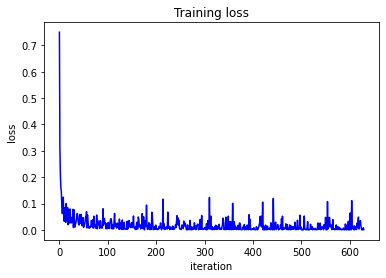

In [13]:
history = []

for i in range(epochs):
    model.train()
    for x, y_true in loader(X, Y, batch_size):
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
    
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        SGD(model.parameters(), model.grad_parameters(), learning_rate)
        history.append(loss)

plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [14]:
accuracy(model, X, Y)

0.997

Мы тут пропустили много важных деталей: валидация, подсчет точности (кроссэнтропия не очень информативна), регуляризация. Вам всё это нужно будет реализовать потом самим.

# Теперь сами

In [15]:
import os
from sklearn.datasets import fetch_openml
# эти библиотеки нужны только для того, чтобы скачать MNISt

if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r',  allow_pickle=True) as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_openml('mnist_784')
    # очень важно его отнормировать -- см. Linear в hw_framework
    X = mnist.data / 255.0
    y = mnist.target
    np.savez('mnist.npz', X=X, y=y)

Переведите лейблы в one-hot.

In [16]:
import pandas as pd
y = pd.get_dummies(y).to_numpy(dtype=np.float64)

Разделите датасет на train и validation.

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

Теперь напишите модель и train loop. Можете начать с адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* поиграйтесь с архитектурами;
* поиграйтесь с learning rate и batch_size;
* сделайте learning rate decay;
* сделайте data augmentation.

Have fun. Дедлайн — не две недели, а до конца курса.

In [39]:
model = Sequential(
    Linear(28 * 28, 300),
    ReLU(),
#     Dropout(0.4),
    Linear(300, 100),
    ReLU(),
#     Dropout(0.4),
    Linear(100, 30),
    ReLU(),
#     Dropout(0.4),
    Linear(30, 10),
    SoftMax()
)

In [40]:
epochs = 100
batch_size = 128
learning_rate = 1e-3

criterion = CrossEntropy()

Epoch: 0, train acc: 0.9154, val acc: 0.9110
Epoch: 1, train acc: 0.9497, val acc: 0.9419
Epoch: 2, train acc: 0.9655, val acc: 0.9554
Epoch: 3, train acc: 0.9781, val acc: 0.9655
Epoch: 4, train acc: 0.9795, val acc: 0.9647
Epoch: 5, train acc: 0.9760, val acc: 0.9614
Epoch: 6, train acc: 0.9864, val acc: 0.9714


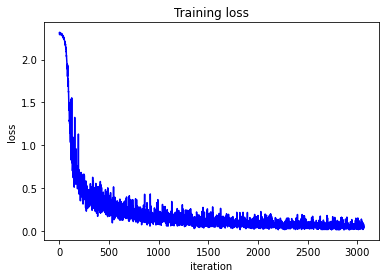

In [41]:
history = []
train_acc = []
val_acc = []

for i in range(epochs):
    model.train()
    for x, y_true in loader(X_train, y_train, batch_size):
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
    
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        SGD(model.parameters(), model.grad_parameters(), learning_rate)

        history.append(loss)
    
    cur_train_acc = accuracy(model, X_train, y_train)
    cur_val_acc = accuracy(model, X_val, y_val)
    train_acc.append(cur_train_acc)
    val_acc.append(cur_val_acc)
    print(f'Epoch: {i}, train acc: {cur_train_acc:.4f}, val acc: {cur_val_acc:.4f}')
    if cur_val_acc >= 0.97:
        break

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

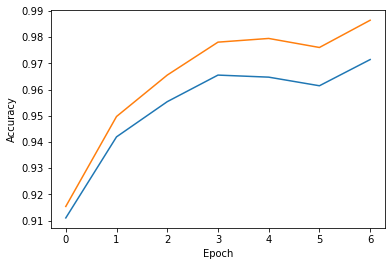

In [46]:
import matplotlib.pyplot as plt

plt.plot(np.arange(7), val_acc, )
plt.plot(np.arange(7), train_acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()